In [2]:
import ml
reload(ml)
from ml import *
import timeit
import scipy
import operator
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from __future__ import division
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [36]:
bid_features = ["ListingKey", "MemberKey", "Bid_Key", "ListingStatus", 'Status']
completed_bids_features = ["Member_Key", "MemberKey", "ListingStatus"]
winning_bids_features = ["Member_Key", "MemberKey", "Status"]
total_bids_features = ["Member_Key", "MemberKey", "Bid_Key"]
member_keys = list(set(bid_data.MemberKey))

In [9]:
# Import Bid Data
bid_data = pd.read_csv("../Data/bid_notick.txt", sep="|")
bid_data['Member_Key'] = bid_data.MemberKey
bid_data.sample(5)

,Amount,CreationDate,Bid_Key,ListingKey,ListingStatus,MemberKey,MinimumRate,MinimumYield,ParticipationAmount,Status,ModifiedDate,Unnamed: 11,Member_Key
8137072,66.080,2011-03-14 09:54:02,17E63613573692741A229E1,1E6935087559483775027CE,Withdrawn,574333730608410709EC02B,nan,nan,66.080,Winning,2011-03-14 09:54:02,nan,574333730608410709EC02B
2623442,100.000,2007-10-06 07:22:50,7D4F3505729596022C57A25,52463401436134859643D08,Completed,94E93380361998952C11221,nan,nan,100.000,Winning,2007-10-06 07:22:50,nan,94E93380361998952C11221
9244554,29.000,2011-12-02 17:19:35,941E3636511916657B5765F,65353531868516871E6261C,Expired,2AE43532774219004D85D6E,nan,nan,29.000,Winning,2011-12-02 17:19:35,nan,2AE43532774219004D85D6E
9319382,25.000,2012-01-12 12:27:51,3F2F364115152981051EB29,A0CA3533768259391539AE0,Completed,DBD635131832616533D27CF,nan,nan,25.000,Winning,2012-01-12 12:27:51,nan,DBD635131832616533D27CF
8856969,25.000,2011-09-05 05:13:37,4A643629172254985B79AE0,82503524688785772799843,Completed,5B2C3521021846775D1674B,nan,nan,25.000,Winning,2011-09-05 05:13:37,nan,5B2C3521021846775D1674B


## All Lenders

In [20]:
member_df = pd.DataFrame()
member_df["MemberKey"] = member_keys
member_df.sample(5)

,MemberKey
8622,712F3374432697986DBC017
13607,0F2C33892323128667DC096
41092,6ED9339501740317475B77A
55740,D91934176405751859F1AF4
50991,9F9F3365535362920B6FF65


## Lender Total Bids

In [37]:
f_total_bids = {'MemberKey': ['max'],
                'Bid_Key': ['count']
}

In [38]:
# Member total bids: funded and unfunded listings
member_total_bids_df = pd.DataFrame(bid_data[total_bids_features].groupby("Member_Key").agg(f_total_bids).as_matrix())
member_total_bids_df = member_total_bids_df.rename(index=str, 
                                                                   columns={0: "MemberKey", 
                                                                            1: "TotalBids"})
member_total_bids_df.sample(5)

,MemberKey,TotalBids
21022,51853421742021317A04A5F,224
27263,69EC3467396591051B93C9F,6
4617,12353409912787251BAE5A9,135
13326,341134190261837536003D3,201
1421,055B3431680902503C54FCC,3


## Lender Completed Bids

In [22]:
f_completed_bids = {'MemberKey': ['max'],
                    'ListingStatus': ['count']
}

In [18]:
# Member completed bids: funded and unfunded listings
member_completed_bids_df = pd.DataFrame(bid_data[completed_bids_features].loc[bid_data["ListingStatus"]=="Completed"].groupby("Member_Key").agg(f_completed_bids).as_matrix())
member_completed_bids_df = member_completed_bids_df.rename(index=str, 
                                                                   columns={0: "MemberKey", 
                                                                            1: "CompletedBids"})
member_completed_bids_df.sample(5)

,MemberKey,CompletedBids
4100,108E341538998181671B66F,12
49035,C35B3497603394585A69DEB,41
35925,8F3F3422293865553A0D342,808
19063,4BA63418530362285E50D64,37
8023,203F33769654721015CAE2B,269


## Lender Winning Bids

In [23]:
f_winning_bids = {'MemberKey': ['max'],
                  'Status': ['count']
}

In [35]:
# Lender winning bids: funded and unfunded listings
member_winning_bids_df = pd.DataFrame(bid_data[winning_bids_features].loc[bid_data["Status"]=="Winning"].groupby("Member_Key").agg(f_winning_bids).as_matrix())
member_winning_bids_df = member_winning_bids_df.rename(index=str, 
                                                                   columns={0: "WinningBids", 
                                                                            1: "MemberKey"})
member_winning_bids_df.sample(5)

,WinningBids,MemberKey
51192,5,CD993385665288010A7ACBC
39379,62,9EA834124663285727E0044
24534,35,623A336513433994397C8F5
29684,115,77483374645708150B6FA80
53852,3,D8403469741418870568A72


## Merge Dataframes

In [58]:
# Lender features from funded and unfunded listings
lender_df = member_df.merge(member_total_bids_df, on="MemberKey", how="inner")
lender_df = lender_df.merge(member_completed_listings_df, on="MemberKey", how="left")
lender_df = lender_df.merge(member_winning_bids_df, on="MemberKey", how="left")
# Lender distinct completed bids / lender total bids
lender_df["BidCompletionRate"] = lender_df['CompletedBids'] / lender_df['TotalBids']
# lender distinct winning bids / lender total bids
lender_df["BidWinningRate"] = lender_df['WinningBids'] / lender_df['TotalBids']
lender_df = lender_df.fillna(0)
lender_df.sample(10)

,MemberKey,TotalBids,CompletedBids,WinningBids,BidCompletionRate,BidWinningRate
25441,F41B3431441765144ED65FA,6,6,4,1.000,0.667
12969,19443405404701690AE1A60,164,91,143,0.555,0.872
26104,94AA35036773760558FFA42,11,7,11,0.636,1.000
26878,62003407149589698B4C832,113,88,27,0.779,0.239
33060,3C683417059281336948CD2,9,4,6,0.444,0.667
14480,EAAB3416805931679ABA14B,28,26,9,0.929,0.321
64254,E59334269153087473D7AC1,193,116,116,0.601,0.601
9416,BE6E33708666074324258AC,390,336,285,0.862,0.731
35444,B57D3377305008259E48DE8,162,114,101,0.704,0.623
24430,F5573381362510514D51160,26,25,9,0.962,0.346


## Lender Feature Engineering

In [64]:
lender_bid_df = bid_data[["ListingKey","MemberKey"]].merge(lender_df, on="MemberKey", how="left")
lender_bid_df["Listing_Key"] = lender_bid_df["ListingKey"]
lender_bid_df.head(20)

,ListingKey,MemberKey,TotalBids,CompletedBids,WinningBids,BidCompletionRate,BidWinningRate,Listing_Key
0,D6473365888221963456102,F4273365023760472DBD934,266,217,147,0.816,0.553,D6473365888221963456102
1,D6473365888221963456102,F4273365023760472DBD934,266,217,147,0.816,0.553,D6473365888221963456102
2,3B09336533376614186EEF7,F4273365023760472DBD934,266,217,147,0.816,0.553,3B09336533376614186EEF7
3,601833660859080305A2AC3,F4273365023760472DBD934,266,217,147,0.816,0.553,601833660859080305A2AC3
4,601833660859080305A2AC3,F4273365023760472DBD934,266,217,147,0.816,0.553,601833660859080305A2AC3
5,73AB3364393429683903176,F4273365023760472DBD934,266,217,147,0.816,0.553,73AB3364393429683903176
6,73AB3364393429683903176,F4273365023760472DBD934,266,217,147,0.816,0.553,73AB3364393429683903176
7,73AB3364393429683903176,F4273365023760472DBD934,266,217,147,0.816,0.553,73AB3364393429683903176
8,9AF5336547891402212A6FC,F4273365023760472DBD934,266,217,147,0.816,0.553,9AF5336547891402212A6FC
9,510133648179460628B9387,F4273365023760472DBD934,266,217,147,0.816,0.553,510133648179460628B9387


In [66]:
print len(lender_df)
print len(member_df)
print len(lender_bid_df)

65756
65756
9732656


In [71]:
lender_bid_fe = pd.DataFrame(lender_bid_df.groupby(["Listing_Key","MemberKey"]).agg(max).as_matrix())
lender_bid_fe.sample(10)

,0,1,2,3,4,5
8182578,EE4C33853196530101DDD07,20359,5749,17130,0.282,0.841
3904700,70A4352872409037580313C,3651,2087,3538,0.572,0.969
7207547,D16733928719425136CA404,50,43,14,0.860,0.280
8192731,EE9734036643578723C1456,184,135,104,0.734,0.565
1557043,2D1C3432969045668E4800F,23,15,12,0.652,0.522
2049682,3B0B340501016081423875E,818,623,542,0.762,0.663
3988058,73093512348177874A8FC3F,4220,2447,3678,0.580,0.872
7737606,E0F433706659637850CCC1A,21194,162,21057,0.008,0.994
3683383,6A803404221798400D8EDAF,187,121,77,0.647,0.412
4386488,7F093416961197179ED130D,144,99,117,0.688,0.812


In [77]:
lender_bid_fe = lender_bid_fe.rename(index=str, 
                                   columns={0: "ListingKey", 
                                            1: "LenderTotalBids",
                                            2: "LenderCompletedBids",
                                            3: "LenderWinningBids",
                                            4: "LenderBidCompletionRate",
                                            5: "LenderBidWinningRate"})
lender_bid_fe.head(10)

,ListingKey,LenderTotalBids,LenderCompletedBids,LenderWinningBids,LenderBidCompletionRate,LenderBidWinningRate
0,00003383856420083050622,2612,1467,1553,0.562,0.595
1,00003383856420083050622,122,62,70,0.508,0.574
2,00003405662222292C12B86,32051,504,31707,0.016,0.989
3,000034085359462718B9059,19068,6067,17591,0.318,0.923
4,000034203787284229CBEF1,2772,1140,2161,0.411,0.780
5,000034203787284229CBEF1,3436,1849,2827,0.538,0.823
6,00003423466422120D65CA3,1058,425,709,0.402,0.670
7,00003423466422120D65CA3,278,167,151,0.601,0.543
8,00003423466422120D65CA3,4989,2057,3819,0.412,0.765
9,00003423466422120D65CA3,261,128,121,0.490,0.464


In [78]:
# Save data
# lender_bid_fe.to_csv("../Data/lender_bid_fe.csv", index=False)

## Import Data from CSV

In [18]:
# Listing Level Bid Data
lender_data = pd.read_csv("../Data/ProjectLevelData.txt", sep="|")
# Filter Funded (Repaid and Defaulted) Listings
lender_data = lender_data[['ListingKey', 'RepaidOrNot']]
lender_data = lender_data.loc[(lender_data['RepaidOrNot']==True) | (lender_data['RepaidOrNot']==False)]
lender_data.head(5)

,ListingKey,RepaidOrNot
17,00033425227988088FA6752,True
21,000433785890431972B4743,False
38,00083422661625108817246,True
46,000A34209897973969CFA81,True
56,000D3410451511356B08F17,True


In [19]:
lender_bid_fe = pd.read_csv('../Data/lender_bid_fe.csv')
lender_bid_fe.head(5)

,ListingKey,LenderTotalBids,LenderCompletedBids,LenderWinningBids,LenderBidCompletionRate,LenderBidWinningRate
0,00003383856420083050622,2612,1467,1553,0.562,0.595
1,00003383856420083050622,122,62,70,0.508,0.574
2,00003405662222292C12B86,32051,504,31707,0.016,0.989
3,000034085359462718B9059,19068,6067,17591,0.318,0.923
4,000034203787284229CBEF1,2772,1140,2161,0.411,0.780


In [20]:
def greaterThanX(totalBids):
    result = [bid for bid in totalBids if bid > 50 and bid < 200]
    return len(result)

## Average Aggregation

In [21]:
f_avg_lender_fe =  {'ListingKey': ['max'],
                'LenderTotalBids': ['mean'],
                'LenderCompletedBids': ['mean'],
                'LenderWinningBids': ['mean'],
                'LenderBidCompletionRate': ['mean'],
                'LenderBidWinningRate': ['mean']
}

In [22]:
start = timeit.default_timer()
lender_bid_fe_avg = lender_bid_fe
lender_bid_fe_avg['Listing_Key'] = lender_bid_fe.ListingKey
# Convert columns to numeric
cols = lender_bid_fe_avg.columns.drop(['ListingKey', 'Listing_Key'])
lender_bid_fe_avg[cols] = lender_bid_fe_avg[cols].apply(pd.to_numeric, errors='coerce')
# Apply group by and aggregate
avg_lender_fe_df = pd.DataFrame(lender_bid_fe_avg.groupby("Listing_Key").agg(f_avg_lender_fe).as_matrix())
# Rename columns
avg_lender_fe_df = avg_lender_fe_df.rename(index=str, 
                                           columns={0: "ListingKey", 
                                                    1: "AvgLenderWinningBids",
                                                    2: "AvgLenderBidCompletionRate",
                                                    3: "AvgLenderCompletedBids",
                                                    4: "AvgLenderBidWinningRate",
                                                    5: "AvgLenderTotalBids"})
stop = timeit.default_timer() 
print "Avg Lender feature engineering completed in %s minutes." % ((stop - start)/60)
avg_lender_fe_df.head()

Avg Lender feature engineering completed in 0.599899225 minutes.


,ListingKey,AvgLenderWinningBids,AvgLenderBidCompletionRate,AvgLenderCompletedBids,AvgLenderBidWinningRate,AvgLenderTotalBids
0,00003383856420083050622,811.500,0.535,764.500,0.584,1367.000
1,00003405662222292C12B86,31707.000,0.016,504.000,0.989,32051.000
2,000034085359462718B9059,17591.000,0.318,6067.000,0.923,19068.000
3,000034203787284229CBEF1,2494.000,0.475,1494.500,0.801,3104.000
4,00003423466422120D65CA3,1052.607,0.521,636.583,0.625,1449.667


## Median Aggregation

In [23]:
f_median_lender_fe =  {'ListingKey': ['max'],
                       'LenderTotalBids': ['median'],
                        'LenderCompletedBids': ['median'],
                        'LenderWinningBids': ['median'],
                        'LenderBidCompletionRate': ['median'],
                        'LenderBidWinningRate': ['median']
}

In [24]:
# lender_bid_fe = lender_bid_fe.drop('LenderTotalBids', axis=1)
# lender_bid_fe.head(5)

In [25]:
start = timeit.default_timer()
lender_bid_fe_median = lender_bid_fe
lender_bid_fe_median['Listing_Key'] = lender_bid_fe.ListingKey
# Convert columns to numeric
cols = lender_bid_fe_median.columns.drop(['ListingKey', 'Listing_Key'])
lender_bid_fe_median[cols] = lender_bid_fe_median[cols].apply(pd.to_numeric, errors='coerce')
# Apply group by and aggregate
median_lender_fe_df = pd.DataFrame(lender_bid_fe_median.groupby("Listing_Key").agg(f_median_lender_fe).as_matrix())
# Rename columns
median_lender_fe_df = median_lender_fe_df.rename(index=str, 
                                           columns={0: "ListingKey", 
                                                    1: "MedianLenderCompletedBids",
                                                    2: "MedianLenderWinningBids",
                                                    3: "MedianLenderBidWinningRate",
                                                    4: "MedianLenderBidCompletionRate",
                                                    5: "MedianLenderTotalBids"}) #TODO: Check order of these columns
stop = timeit.default_timer() 
print "Avg Lender feature engineering completed in %s minutes." % ((stop - start)/60)
median_lender_fe_df.head()

Avg Lender feature engineering completed in 0.519968475 minutes.


,ListingKey,MedianLenderCompletedBids,MedianLenderWinningBids,MedianLenderBidWinningRate,MedianLenderBidCompletionRate,MedianLenderTotalBids
0,00003383856420083050622,811.500,0.535,764.500,0.584,1367.000
1,00003405662222292C12B86,31707.000,0.016,504.000,0.989,32051.000
2,000034085359462718B9059,17591.000,0.318,6067.000,0.923,19068.000
3,000034203787284229CBEF1,2494.000,0.475,1494.500,0.801,3104.000
4,00003423466422120D65CA3,317.500,0.520,238.000,0.636,533.500


## Standard Deviation Aggregation

In [26]:
f_std_lender_fe =  {'ListingKey': ['max'],
                    'LenderTotalBids': ['std'],
                    'LenderCompletedBids': ['std'],
                    'LenderWinningBids': ['std'],
                    'LenderBidCompletionRate': ['std'],
                    'LenderBidWinningRate': ['std']
}

In [27]:
start = timeit.default_timer()
lender_bid_fe_std = lender_bid_fe
lender_bid_fe_std['Listing_Key'] = lender_bid_fe.ListingKey
# Convert columns to numeric
cols = lender_bid_fe_std.columns.drop(['ListingKey', 'Listing_Key'])
lender_bid_fe_std[cols] = lender_bid_fe_std[cols].apply(pd.to_numeric, errors='coerce')
# Apply group by and aggregate
std_lender_fe_df = pd.DataFrame(lender_bid_fe_std.groupby("Listing_Key").agg(f_std_lender_fe).as_matrix())
# Rename columns
std_lender_fe_df = std_lender_fe_df.rename(index=str, 
                                           columns={0: "ListingKey", 
                                                    1: "StdLenderCompletedBids",
                                                    2: "StdLenderWinningBids",
                                                    3: "StdLenderBidWinningRate",
                                                    4: "StdLenderBidCompletionRate",
                                                    5: "StdLenderTotalBids"}) #TODO: Check order of these columns
std_lender_fe_df = std_lender_fe_df.fillna(-1)
stop = timeit.default_timer() 
print "Avg Lender feature engineering completed in %s minutes." % ((stop - start)/60)
std_lender_fe_df.head()

Avg Lender feature engineering completed in 0.498579575 minutes.


,ListingKey,StdLenderCompletedBids,StdLenderWinningBids,StdLenderBidWinningRate,StdLenderBidCompletionRate,StdLenderTotalBids
0,00003383856420083050622,1048.639,0.038,993.485,0.015,1760.696
1,00003405662222292C12B86,-1.000,-1.000,-1.000,-1.000,-1.000
2,000034085359462718B9059,-1.000,-1.000,-1.000,-1.000,-1.000
3,000034203787284229CBEF1,470.933,0.090,501.339,0.031,469.519
4,00003423466422120D65CA3,2325.522,0.154,1026.994,0.190,2796.801


## Merge Features

In [28]:
lender_data_fe = lender_data.merge(avg_lender_fe_df, on="ListingKey")
lender_data_fe = lender_data_fe.merge(median_lender_fe_df, on="ListingKey")
lender_data_fe = lender_data_fe.merge(std_lender_fe_df, on="ListingKey")
lender_data_fe['RepaidOrNot'] = lender_data_fe['RepaidOrNot'].astype(int)
lender_data_fe.head(10)

,ListingKey,RepaidOrNot,AvgLenderWinningBids,AvgLenderBidCompletionRate,AvgLenderCompletedBids,AvgLenderBidWinningRate,AvgLenderTotalBids,MedianLenderCompletedBids,MedianLenderWinningBids,MedianLenderBidWinningRate,MedianLenderBidCompletionRate,MedianLenderTotalBids,StdLenderCompletedBids,StdLenderWinningBids,StdLenderBidWinningRate,StdLenderBidCompletionRate,StdLenderTotalBids
0,00033425227988088FA6752,1,820.500,0.655,695.214,0.731,1118.929,538.000,0.677,486.000,0.796,698.000,707.599,0.137,695.371,0.144,1045.389
1,000433785890431972B4743,0,822.966,0.681,847.724,0.694,1228.655,368.000,0.691,320.000,0.678,535.000,1034.407,0.128,1148.751,0.144,1595.722
2,00083422661625108817246,1,644.230,0.749,647.127,0.650,933.778,225.000,0.760,292.500,0.664,388.000,990.901,0.091,930.350,0.150,1419.807
3,000A34209897973969CFA81,1,124.500,0.761,213.500,0.475,280.000,124.500,0.761,213.500,0.475,280.000,115.258,0.003,212.839,0.061,278.600
4,000D3410451511356B08F17,1,490.477,0.696,465.098,0.600,740.649,191.500,0.725,217.000,0.600,336.000,844.092,0.122,602.366,0.172,1092.335
5,00143395229257559A91663,0,1004.514,0.626,729.162,0.678,1380.405,249.000,0.635,260.000,0.682,556.000,1828.404,0.149,938.953,0.166,2237.125
6,00153399719267548BE59C1,0,935.684,0.630,725.955,0.641,1308.045,251.000,0.656,265.000,0.650,398.000,2084.223,0.107,1146.059,0.175,2523.599
7,0018336527159010012E040,1,761.883,0.743,730.543,0.646,1088.234,291.000,0.747,311.500,0.632,442.500,1322.608,0.114,1030.938,0.151,1692.730
8,001B336610801804832CE14,1,582.109,0.748,602.069,0.625,875.505,242.000,0.755,314.000,0.627,445.000,886.737,0.094,743.108,0.152,1198.999
9,001C3375545731729D10129,0,1518.389,0.625,730.722,0.622,1969.833,177.000,0.710,219.000,0.618,336.500,3049.100,0.191,1139.896,0.135,3706.604


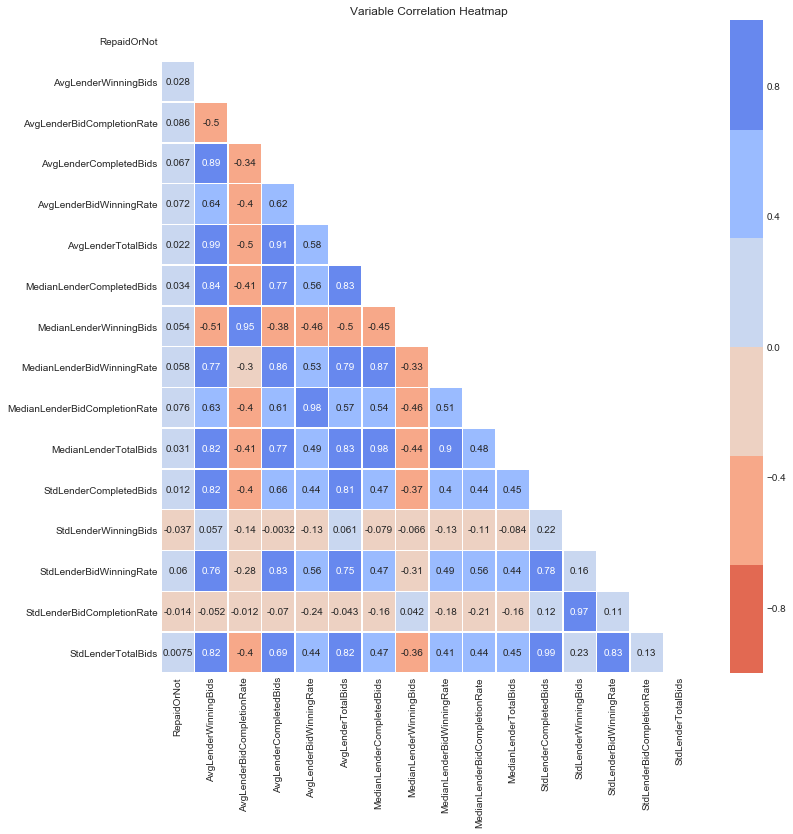

In [29]:
corr = lender_data_fe[lender_data_fe.columns[1:]].apply(pd.to_numeric, errors='coerce').corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,12))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        linewidths=.5,
        vmin=-1,
        vmax=1,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

In [30]:
lender_data_fe = lender_data_fe.drop('RepaidOrNot', axis=1)
lender_data_fe.to_csv('../Data/lender_bid_attr.csv', index=False)